In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage
from skimage.draw import draw
from scipy import interpolate
import copy
import pickle

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [3]:
%%time
psd_setting = {'ca' : 80, # of the 80% CA given
               'ovs': 4096,
               'surf_units': u.micron,
               'ring_width': 3,
               'diam_ca100': (50*u.mm),
               'kmid_ll': (0.1/u.mm),
               'khigh_ll': (1/u.mm),
               'label':'2in'}

fileloc = 'zygo_data/flat_mirrors/fixed_fits/flat_{0}_ca{1}_avg_dustmask_PSD_test1.fits'.format(psd_setting['label'], psd_setting['ca'])

avg_psd = psd.surfPSD(surf_name='fm2inch_avgPSD')
avg_psd.open_psd(psd_fileloc=fileloc, psd_type='cal', var_unit=u.nm)
avg_psd.calc_rms_set(kmid_ll=psd_setting['kmid_ll'], khigh_ll=psd_setting['khigh_ll'], pwr_opt=avg_psd.psd_cal)
avg_psd.calc_psd_radial(psd_setting['ring_width'])

CPU times: user 1min, sys: 21.8 s, total: 1min 21s
Wall time: 1min 20s


In [4]:
i_start = [0, 26, 145]
i_end = i_start[1:]
i_end.append(600)

lo = [0.8, 0.25, 0.05]
L0 = [40*u.mm, 50*u.mm, 1*u.mm]
rms_sr = [0.0005*u.nm, 0.0005*u.nm, 0.05*u.nm]
psd_scl = [[1.0, 0.0, 1.0], 
           [0.9, 0.1, 1.1]]

mdl_set = []
for j in range(0, len(i_start)):
    mdl = psd.model(region_num=j, ind_start=i_start[j], ind_end=i_end[j],
                k_radial=avg_psd.k_radial, p_radial=avg_psd.psd_radial_cal,
                k_min=avg_psd.k_min, k_max=avg_psd.k_max)
    mdl.solve_lsf()
    mdl.extend_k(delta_k=avg_psd.delta_k, k_limit=80/u.mm)
    mdl.calc_bsr(rms_sr=rms_sr[j])
    mdl.calc_model_full(L0=L0[j], lo=lo[j], k_range=mdl.k_extend)
    mdl_set.append(mdl)

# apply the PSD scaling
mdl_sum = np.zeros((len(psd_scl), len(mdl.psd_full)))
for j in range(0, len(psd_scl)): 
    for js in range(0, len(i_start)):
        mdl_sum[j] = mdl_sum[j] + (mdl_set[js].psd_full.value*psd_scl[j][js])

/home/jhen/XWCL/code/model_kit/model_kit/psd_functions.py:340: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A, y)[0] # y = mx + c linear equation


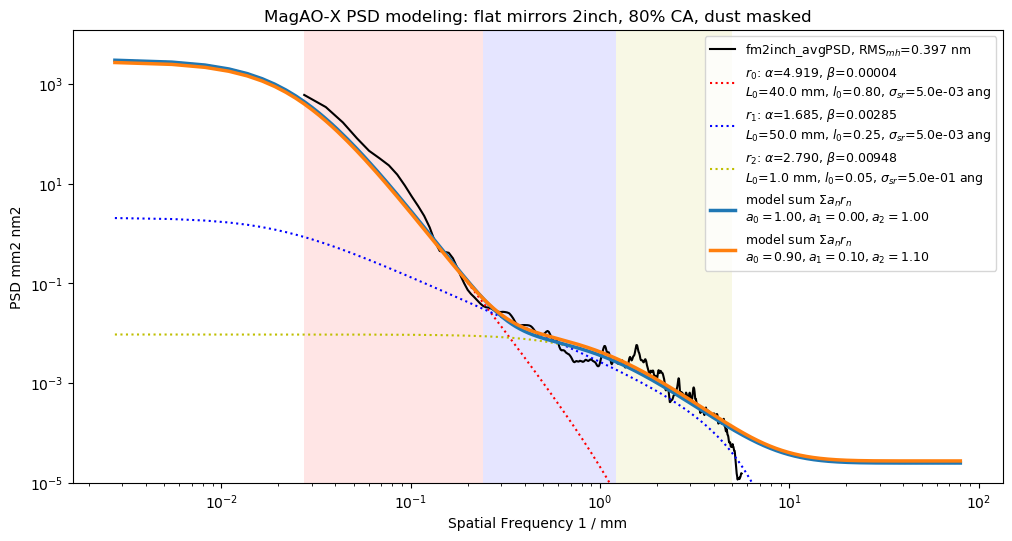

In [6]:
color_list=['r', 'b','y']
plt.figure(figsize=[12,6], dpi=100)
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS{1}={2:.3f}'.format(avg_psd.surf_name,r'$_{mh}$', avg_psd.rms_mh))
for j in range(0, len(i_start)):
    plt.loglog(mdl_set[j].k_extend.value, mdl_set[j].psd_full.value, color_list[j]+':', linewidth=1.5,
               label='{0}: {1}={2:.3f}, {3}={4:.5f}\n{5}={6:.1f}, {7}={8:.2f}, {9}={10:.1e} ang'.format(r'$r_{0}$'.format(mdl_set[j].region_num), r'$\alpha$', mdl_set[j].alpha, 
                                                                                                    r'$\beta$', mdl_set[j].beta.value, r'$L_{0}$',L0[j], r'$l_{0}$', lo[j], 
                                                                                                    r'$\sigma_{sr}$', rms_sr[j].to(u.angstrom).value))
    plt.axvspan(avg_psd.k_radial[i_start[j]].value, avg_psd.k_radial[i_end[j]].value, facecolor=color_list[j], alpha=0.1)

for j in range(0, len(psd_scl)):
    txt_print = r'$a_{0}={1:.2f}, a_{2}={3:.2f}, a_{4}={5:.2f}$'.format(0, psd_scl[j][0], 1, psd_scl[j][1], 2, psd_scl[j][2])
    plt.loglog(mdl_set[j].k_extend.value, mdl_sum[j], linewidth=2.5, label='model sum {0}\n{1}'.format(r'$\Sigma a_{n}r_{n}$', txt_print))

plt.ylim(bottom=1e-5)
plt.xlabel('Spatial Frequency {0}'.format(avg_psd.k_radial.unit))
plt.ylabel('PSD {0}'.format(avg_psd.psd_radial_cal.unit))
plt.title('MagAO-X PSD modeling: flat mirrors 2inch, {0}% CA, dust masked'.format(psd_setting['ca']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
psd_parm = []
for j in range(0, len(mdl_set)):
    parameters = [mdl_set[j].alpha, mdl_set[j].beta, mdl_set[j].L0, mdl_set[j].lo, mdl_set[j].bsr]
    psd_parm.append(parameters)
    
psd_dict = {'psd_fm2in': psd_parm,
            'psd_fm2in_weight': psd_scl[0]}

# save the directory as a pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/psd_parms_{0}.pickle'.format(psd_setting['label'])
with open(filename,'wb') as psd_parameter_file:
    pickle.dump(psd_dict, psd_parameter_file, protocol=4)

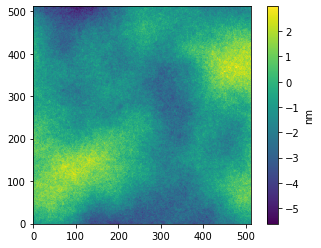

In [13]:
sg = psd.surfgen(dx=6.1524325E-02*u.mm, npix_diam=512, oversamp=2048)
sg.calc_psd(psd_parm=psd_parm, psd_weight=psd_scl[0])
sg.build_surf(opd_reflect=False)

plt.imshow(sg.surface.value, origin='lower')
plt.colorbar().set_label(sg.surface.unit)

In [14]:
sg.write_surf_file(file_folder='/home/jhen/XWCL/code/MagAOX/PSD/',
                   filename='oap_test0.fits')
test=fits.open('/home/jhen/XWCL/code/MagAOX/PSD/oap_test0.fits')[0]
test.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
OPD_UNIT= 'nm      '           / Units for surface OPD data                     
OPD_REFL=                    F / Boolean if surface OPD/2 for reflection        
OP_DIAM =           31.5004544 / Physical diameter for clear aperture [mm]      
SCRNSZ  =                 2048 / Array size for screen generation               
PIXSCALE=          0.061524325 / pixel scale [mm/pix]                           
DELTA_K = 0.007936393450883046 / Spatial frequency lateral resolution [1 / mm]  
ALPHA0  =    4.919317621009123 / PSD alpha (exponent)                           
BETA0   = 4.02757630507673E-

## Regional mapping
Preliminary insight to visually choosing regions with fit best for simple model.

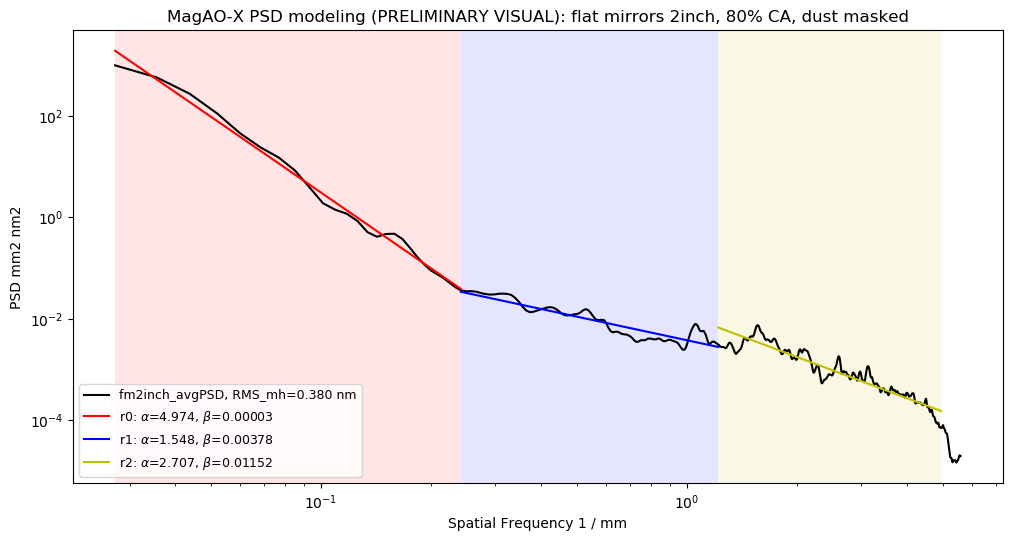

In [62]:
i_start = [0, 26, 145]
i_end = i_start[1:]
i_end.append(600)

mdl_simp = []
for j in range(0, len(i_start)):
    mdl = psd.model(region_num=j, ind_start=i_start[j], ind_end=i_end[j],
                k_radial=avg_psd.k_radial, p_radial=avg_psd.psd_radial_cal,
                k_min=avg_psd.k_min, k_max=avg_psd.k_max)
    mdl.solve_lsf()
    mdl.calc_model_simple()
    mdl_simp.append(mdl)

alpha_tone = 0.1
color_list=['r', 'b','y']
plt.figure(figsize=[12,6],dpi=100)
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_mh={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_mh))
for j in range(0, len(i_start)):
    plt.loglog(mdl_simp[j].k_data.value, mdl_simp[j].model_simple.value, color_list[j], linewidth=1.5,
               label='r{0}: {1}={2:.3f}, {3}={4:.5f}'.format(mdl_simp[j].region_num, r'$\alpha$', mdl_set[j].alpha, r'$\beta$', mdl_set[j].beta.value))
    plt.axvspan(avg_psd.k_radial[i_start[j]].value, avg_psd.k_radial[i_end[j]].value, 
                facecolor=color_list[j], alpha=alpha_tone)
plt.xlabel('Spatial Frequency {0}'.format(avg_psd.k_radial.unit))
plt.ylabel('PSD {0}'.format(avg_psd.psd_radial_cal.unit))
plt.title('MagAO-X PSD modeling (PRELIMINARY VISUAL): flat mirrors 2inch, {0}% CA, dust masked'.format(psd_parms['ca']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))